In [ ]:
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [ ]:
idx = torch.arange(100, device='cuda')


### ¿Qué es una máscara?

En self-attention tenemos una matriz de atención de tamaño [T, T]:

filas = posiciones query (qué token está “preguntando”)

columnas = posiciones key (a qué token puede “mirar”)

Las funciones devuelven un tensor booleano mask de tamaño [T, T] donde:

mask[q, k] == True → la posición q puede atender a la posición k

mask[q, k] == False → esa conexión se prohíbe (y luego se convertirá en -inf antes del softmax)

T = tamaño de la secuencia

In [ ]:
## Máscaras para los patrones (dense, strided, fixed)

def build_causal_mask(seq_len, device=None): # para crear la mascara densa causal estandar: cada token en posicion t puede atender a sí mismo
    device = device or "cpu"                # y a todos los tokens anteriores, pero no al futuro. Típica mascara triangular inferior.
    idx = torch.arange(seq_len, device=device) # seq_len: long de la sec T, idx: Crea un vector que reprrsenta las posiciones de la sec
    q_idx = idx.view(-1, 1)                   # q_idx: [T,1] cada fila corresponde a un índice query.
    print(q_idx)
    k_idx = idx.view(1, -1)                    # k_idx: [1,T] cada columna corresponde a un índice key.
    mask = k_idx <= q_idx  # [T, T] comparamos todas las combinaciones (q, k): True si k <= q y False si k > q
    return mask

In [ ]:
build_causal_mask(4)

tensor([[0],
        [1],
        [2],
        [3]])


tensor([[ True, False, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True,  True,  True]])

In [ ]:
def build_strided_mask(seq_len, local_ctx=32, device=None): # Construye una máscara sparse tipo “strided” inspirada en Sparse Transformer
    device = device or "cpu"                                # es causal, no mira al futuro. local_ctx: tamaño ventana local hacia atras
    idx = torch.arange(seq_len, device=device)
    q_idx = idx.view(-1, 1)                       # q_idx: [T,1] cada fila corresponde a un índice query.
    k_idx = idx.view(1, -1)                       # k_idx: [1,T] cada columna corresponde a un índice key.

    causal = k_idx <= q_idx                       # Matriz causal básica [T, T] (triangular inferior)

    local = (q_idx - k_idx) <= local_ctx # (q_idx - k_idx) es una matriz donde la entrada (q, k) vale q - k, un token puede atender a los
    print(local)                          # últimos local_ctx tokens: Si q - k <= local_ctx → k no está demasiado lejos en el pasado
    local = local & causal                # local = local & causal interseccion para no mirar al futuro
    print(local)

    stride = int(math.sqrt(seq_len))      # stride l: lo que me salto entre ventanas, formula tomada del paper
    stride = max(stride, 1)               # asegurando que sea mayor o igual que 1
    print(stride)
    strided = ((q_idx - k_idx) % stride == 0) & causal # ((q_idx - k_idx) % stride == 0) = True cuando la diferencia de índices es múltiplo de stride
    print(strided)
                                # Para una posición q, esto selecciona algunos k espaciados regularmente. Intersectamos con causal para no mirar al futuro.
    mask = local | strided      # Una conexión está permitida si es parte de la ventana local o si cae en una posición "strided".
    return mask


In [ ]:
  build_strided_mask(6, local_ctx=3)

tensor([[ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True]])
tensor([[ True, False, False, False, False, False],
        [ True,  True, False, False, False, False],
        [ True,  True,  True, False, False, False],
        [ True,  True,  True,  True, False, False],
        [False,  True,  True,  True,  True, False],
        [False, False,  True,  True,  True,  True]])
2
tensor([[ True, False, False, False, False, False],
        [False,  True, False, False, False, False],
        [ True, False,  True, False, False, False],
        [False,  True, False,  True, False, False],
        [ True, False,  True, False,  True, False],
        [False,  True, False,  True, False,  True]])


tensor([[ True, False, False, False, False, False],
        [ True,  True, False, False, False, False],
        [ True,  True,  True, False, False, False],
        [ True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True, False],
        [False,  True,  True,  True,  True,  True]])

In [ ]:
def build_fixed_mask(seq_len, local_ctx=32, num_global=8, device=None):
    device = device or "cpu"
    idx = torch.arange(seq_len, device=device)
    q_idx = idx.view(-1, 1)
    k_idx = idx.view(1, -1)

    causal = k_idx <= q_idx

    local = (q_idx - k_idx) <= local_ctx
    local = local & causal
    print(local)

    if num_global > 0:
        global_positions = torch.linspace(
            0, seq_len - 1, steps=num_global, device=device
        ).long()
        print(global_positions)
        is_global_key = torch.zeros(seq_len, dtype=torch.bool, device=device) #Select evenly spaced global tokens.
        print(is_global_key)
        is_global_key[global_positions] = True
        print(is_global_key)
        global_keys = is_global_key.view(1, -1).expand(seq_len, -1)
        print(global_keys)
        global_keys = global_keys & causal
        print(global_keys)
    else:
        global_keys = torch.zeros(seq_len, seq_len, dtype=torch.bool, device=device)

    mask = local | global_keys
    return mask
build_fixed_mask(5, local_ctx=2, num_global=2)

tensor([[ True, False, False, False, False],
        [ True,  True, False, False, False],
        [ True,  True,  True, False, False],
        [False,  True,  True,  True, False],
        [False, False,  True,  True,  True]])
tensor([0, 4])
tensor([False, False, False, False, False])
tensor([ True, False, False, False,  True])
tensor([[ True, False, False, False,  True],
        [ True, False, False, False,  True],
        [ True, False, False, False,  True],
        [ True, False, False, False,  True],
        [ True, False, False, False,  True]])
tensor([[ True, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False,  True]])


tensor([[ True, False, False, False, False],
        [ True,  True, False, False, False],
        [ True,  True,  True, False, False],
        [ True,  True,  True,  True, False],
        [ True, False,  True,  True,  True]])

In [ ]:
## Máscaras para los patrones (dense, strided, fixed)

def build_causal_mask(seq_len, device=None): # para crear la mascara densa causal estandar: cada token en posicion t puede atender a sí mismo
    device = device or "cpu"                # y a todos los tokens anteriores, pero no al futuro. Típica mascara triangular inferior.
    idx = torch.arange(seq_len, device=device) # seq_len: long de la sec T, idx: Crea un vector que reprrsenta las posiciones de la sec
    q_idx = idx.view(-1, 1)                    # q_idx: [T,1] cada fila corresponde a un índice query.
    k_idx = idx.view(1, -1)                    # k_idx: [1,T] cada columna corresponde a un índice key.
    mask = k_idx <= q_idx  # [T, T] comparamos todas las combinaciones (q, k): True si k <= q y False si k > q
    return mask

def build_strided_mask(seq_len, local_ctx=32, device=None): # Construye una máscara sparse tipo “strided” inspirada en Sparse Transformer
    device = device or "cpu"                                # es causal, no mira al futuro. local_ctx: tamaño ventana local hacia atras
    idx = torch.arange(seq_len, device=device)
    q_idx = idx.view(-1, 1)                       # q_idx: [T,1] cada fila corresponde a un índice query.
    k_idx = idx.view(1, -1)                       # k_idx: [1,T] cada columna corresponde a un índice key.

    causal = k_idx <= q_idx                       # Matriz causal básica [T, T] (triangular inferior)

    local = (q_idx - k_idx) <= local_ctx # (q_idx - k_idx) es una matriz donde la entrada (q, k) vale q - k, un token puede atender a los
    local = local & causal                # últimos local_ctx tokens: Si q - k <= local_ctx → k no está demasiado lejos en el pasado
                                          # local = local & causal interseccion para no mirar al futuro
    stride = int(math.sqrt(seq_len))      # stride l: lo que me salto entre ventanas, formula tomada del paper
    stride = max(stride, 1)               # asegurando que sea mayor o igual que 1
    strided = ((q_idx - k_idx) % stride == 0) & causal # ((q_idx - k_idx) % stride == 0) = True cuando la diferencia de índices es múltiplo de stride
                                # Para una posición q, esto selecciona algunos k espaciados regularmente. Intersectamos con causal para no mirar al futuro.
    mask = local | strided      # Una conexión está permitida si es parte de la ventana local o si cae en una posición "strided".
    return mask

def build_fixed_mask(seq_len, local_ctx=32, num_global=8, device=None): #num_global: número de posiciones globales que escogemos a lo largo de la secuencia
    device = device or "cpu"               # Por ejemplo, si T=100 y num_global=5, podríamos obtener posiciones aproximadas [0, 24, 49, 74, 99].
    idx = torch.arange(seq_len, device=device)
    q_idx = idx.view(-1, 1)
    k_idx = idx.view(1, -1)

    causal = k_idx <= q_idx

    local = (q_idx - k_idx) <= local_ctx
    local = local & causal        # hasta aquí misma lógica de las fuunciones anteriores

    if num_global > 0:            # definiendo tokens globales
        global_positions = torch.linspace(
            0, seq_len - 1, steps=num_global, device=device
        ).long()
        is_global_key = torch.zeros(seq_len, dtype=torch.bool, device=device)
        is_global_key[global_positions] = True # is_global_key es un vector [T] donde True indica que esa posición k es global (columna global)
        global_keys = is_global_key.view(1, -1).expand(seq_len, -1) # Convertimos is_global_key a una matriz [1, T] y la expandimos a [T, T]
        global_keys = global_keys & causal # Intersectamos con causal para no romper la estructura temporal
    else:
        global_keys = torch.zeros(seq_len, seq_len, dtype=torch.bool, device=device)

    mask = local | global_keys # Cada query puede ver su ventana local más todos los tokens globales anteriores.
    return mask


Este módulo implementa la autoatención multitestado, pero permite diferentes patrones de dispersión para la máscara de atención:

dense: atención causal completa (transformador estándar)

strided: atención dispersa utilizando ventanas locales + conexiones periódicas escalonadas

fixed: atención dispersa utilizando ventanas locales + un conjunto de tokens globales

In [ ]:
## Clase de self-attention con patrón seleccionable

class SparseSelfAttention(nn.Module):
    """
    Self-attention multi-cabeza con distintos patrones:
    - dense   : atención causal completa
    - strided : atención sparse con stride ~ sqrt(n)
    - fixed   : atención sparse con tokens globales + ventana local
    """

    def __init__(
        self,
        d_model: int,
        n_heads: int,
        pattern: str = "dense",
        local_ctx: int = 32,
        num_global: int = 8,
    ):
        super().__init__()
        assert d_model % n_heads == 0, "d_model debe ser divisible por n_heads"
        assert pattern in ["dense", "strided", "fixed"]
        # definiendo hiperpapametros del modelo
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads # dimensión por cabeza de atención
        self.pattern = pattern
        self.local_ctx = local_ctx
        self.num_global = num_global
        # proyecciones lineales para querys,keys, values y salida
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False) #
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model, bias=False)

    def _build_mask(self, seq_len, device):  # seleccionar qué máscara construir en función del patrón de dispersión
        if self.pattern == "dense":          # se elige la función necesaria del modulo anterior
            mask = build_causal_mask(seq_len, device=device)
        elif self.pattern == "strided":
            mask = build_strided_mask(seq_len, local_ctx=self.local_ctx, device=device)
        elif self.pattern == "fixed":
            mask = build_fixed_mask(
                seq_len,
                local_ctx=self.local_ctx,
                num_global=self.num_global,
                device=device,
            )
        return mask.unsqueeze(0).unsqueeze(0)  # Forma esperada para la difusión con [B, H, T, T]
                                               # Se expande a [1, 1, T, T], por lo que cada lote y cabeza comparten la misma máscara.

    def forward(self, x):
        """
        x: [B, T, C] tensor de esa forma,
        B = batch size
        T = sequence length
        C = d_model
        """
        B, T, C = x.size()
        device = x.device
        # Extrae las dimensiones
        q = self.w_q(x)  # Cada w_* es una capa lineal nn.Linear(d_model, d_model)
        k = self.w_k(x)
        v = self.w_v(x)

        def split_heads(t): # Divide los tensores en multiples cabezas de atención
            return t.view(B, T, self.n_heads, self.d_head).transpose(1, 2) # Reshape [B, T, C] -> [B, T, H, d_head]
                                                                          # Luego transpone a [B, H, T, d_head]
        q = split_heads(q)
        k = split_heads(k)
        v = split_heads(v)

        q = q / math.sqrt(self.d_head)  # Escalanod la matriz q: estabilidad numérrica de QK^T

        attn_logits = torch.matmul(q, k.transpose(-2, -1))  # Calcula los productos escalares entre todos los querys y keys
                                                            # dentro de cada cabeza -> [B,H,T,T]
        mask = self._build_mask(T, device=device)  # Mask es [1, 1, T, T], Se expande a [B, H, T, T]
        attn_logits = attn_logits.masked_fill(~mask, float("-inf")) # Cualquier entrada False en la máscara se sustituye por -inf.
          # Esto obliga a softmax a asignar a estas posiciones una probabilidad ≈ 0. Aquí es donde la dispersión(sparcity) se activa realmente.
        attn_weights = F.softmax(attn_logits, dim=-1) # Softmax sobre la dimensión de keys (dim=-1, el último eje, el de tamaño T).
        # Resultado: attn_weights tiene forma [B, H, T, T], y cada fila (b, h, q, :) es una distribución de probabilidad sobre las keys.
        out = torch.matmul(attn_weights, v)  # [B,H,T,d_head]: v=d_head
                                             #cada query se convierte en combinación lineal de las values permitidas por los pesos de atención.

        out = out.transpose(1, 2).contiguous().view(B, T, C) # out.transpose(1, 2): pasa de [B, H, T, d_head] a [B, T, H, d_head]
        out = self.w_o(out)                                  # .contiguous().view(B, T, C):  H * d_head quedando [B, T, C]
        return out, attn_weights                             # out = self.w_o(out): proyección final a espacio de modelo y mezcla la información entre cabezas
# out: [B, T, C]; attn_weights: [B, H, T, T] (visualizaciones e interpretabilidad)


## Bloque Transformer decoder con nuestra atención

Es una capa de Transformer (decoder o encoder) que combina:
Self-attention (en tu caso, sparse con patrones configurables).
Feed-forward network (FFN) — una MLP aplicada posición a posición.
Residual connections (sumar la entrada a la salida).
Layer normalization — estabiliza el entrenamiento.
Dropout — regularización.

In [ ]:
#Creamos un bloque que use SparseSelfAttention:

class TransformerBlock(nn.Module):
    """
  d_model: dimensionality of token embeddings
  n_heads: number of attention heads
  d_ff: hidden dimension of the feed-forward network
  pattern: type of attention mask ("dense", "strided", "fixed")
  local_ctx, num_global: parameters for sparse attention
  dropout: dropout rate applied to outputs
    """
    def __init__(
        self,
        d_model: int,
        n_heads: int,
        d_ff: int,
        pattern: str = "dense",
        local_ctx: int = 32,
        num_global: int = 8,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.attn = SparseSelfAttention( # Crea una instancia del módulo de atención multi-cabeza con sparsity (la clase anterior)
            d_model=d_model,             # Hereda los hiperparámetros
            n_heads=n_heads,
            pattern=pattern,
            local_ctx=local_ctx,
            num_global=num_global,
        )
        self.ln1 = nn.LayerNorm(d_model) # LayerNorm normaliza características por cada posición
        self.ln2 = nn.LayerNorm(d_model) # Normalizamos antes de pasar por: self-attention (ln1) y feed-forward (ln2)

        """
        Se aplica estructura básica de MPL: (MULTILAYER PERCEPTRON) a cada posición de la secuencia de manera independiente
        d_ff: dimensión de la capa oculta de la red ff
        Rol del MLP en Transformers
        En cada bloque Transformer:
        El self-attention mezcla información entre tokens.
        El MLP transforma cada token de manera independiente, enriqueciendo su representación.
        Por eso se dice que: La atención mezcla señales entre posiciones y el MLP procesa la señal de cada posición.
        """
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff), # Primera capa: nn.Linear(d_model, d_ff): Proyecta la representación de tamaño d_model a un espacio más grande d_ff
            nn.GELU(), # Función de activación: Suaviza la transición entre regiones activas/inactivas (a diferencia de ReLU que “corta” en 0)
            nn.Linear(d_ff, d_model), # Segunda capa: nn.Linear(d_ff, d_model: Proyecta de vuelta al espacio d_model
        )
        self.dropout = nn.Dropout(dropout) # Dropout aleatoriamente pone a cero algunos componentes de la salida con probabilidad dropout
                                           # Ayuda a evitar overfitting y mejora la robustez.

    def forward(self, x):
        # x: [B, T, C]
        # 1) self-attention + residual
        h = self.ln1(x) # Aplica layer normalization antes de la atención
        attn_out, attn_weights = self.attn(h) # h tiene la misma forma [B, T, C], calcula la atención esparcida, devuelve salida de atención y matriz de pesos
        x = x + self.dropout(attn_out) # Sumamos la entrada original x con la salida de la atención. Aplica dropout sobre la salida de attention antes de sumarla.
        """
        La nueva x (después de esta línea) ya incorpora:
        La información original del token
        Información agregada desde otros tokens (via atención)
        regularización por dropout.
        """

        # 2) feed-forward + residual
        h2 = self.ln2(x)   # Aplicamos layer normalization al resultado después de la subcapa de atención
        ff_out = self.ff(h2) # Pasamos h2 por la ffn (h2 -> [B,T,C])
        x = x + self.dropout(ff_out) # Segundo residual : Sumamos la entrada a la FFN (x) con la salida transformada (ff_out con dropout)

        return x, attn_weights  # x: reoresentación trasnformada luego de self attention + residual y feed forward + residual
                                # matriz de pesos de atencion


##  Modelo completo de lenguaje (decoder-only)
Es un modelo de lenguaje auto-regresivo (tipo GPT pequeño) que trabaja a nivel carácter:
Entrada: secuencia de índices de caracteres [B, T].

Salida: logits por carácter [B, T, vocab_size] para predecir el siguiente carácter en cada posición.

Arquitectura interna:

Embedding de tokens (caracteres)

Embedding de posiciones (positional embeddings)

n_layers bloques TransformerBlock (cada uno con atención sparse/dense)

Normalización final + capa lineal hacia vocabulario

Además, todo el comportamiento de sparsity se controla con el parámetro pattern que se pasa hacia abajo a los bloques.

In [ ]:
## Mini transformer
# Embedding de caracteres
# Positional embeddings
# n_layers bloques TransformerBlock
# Capa final que proyecta a vocabulario (logits)
# Con esto, podemos crear el mismo modelo usando pattern="dense", "strided" o "fixed" simplemente cambiando el parámetro.

class SparseTransformerLM(nn.Module):
  """
  Model hyperparameters:
  vocab_size: number of tokens in the vocabulary
  d_model: embedding size and hidden size
  n_heads: number of attention heads
  d_ff: dimension of intermediate feed-forward layers
  n_layers: number of Transformer blocks stacked
  max_seq_len: maximum sequence length supported
  pattern: type of attention mask
  local_ctx, num_global: only used for sparse patterns
  dropout: residual dropout within each block
  """
  def __init__(
        self,
        vocab_size: int,
        d_model: int = 256,
        n_heads: int = 4,
        d_ff: int = 1024,
        n_layers: int = 4,
        max_seq_len: int = 256,
        pattern: str = "dense",
        local_ctx: int = 32,
        num_global: int = 8,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_seq_len = max_seq_len

        self.token_emb = nn.Embedding(vocab_size, d_model) # Este embedding es el que transforma la secuencia discreta en una secuencia de vectores numéricos.
        self.pos_emb = nn.Embedding(max_seq_len, d_model) # Capa de embeddings para añadir informacion posicional a los tokens

        self.layers = nn.ModuleList( # Es una lista especial de PyTorch que registra sus elementos como submódulos
            [                        # Permite que .parameters() vea todos los parámetros dentro
                TransformerBlock(
                    d_model=d_model,
                    n_heads=n_heads,
                    d_ff=d_ff,
                    pattern=pattern,
                    local_ctx=local_ctx,
                    num_global=num_global,
                    dropout=dropout,
                )
                for _ in range(n_layers) # se crean n_layers copias de transformerblock con mismos parámetros
            ]
        )

        self.ln_f = nn.LayerNorm(d_model) # normaliza representaciones finales para controlar escala
        self.head = nn.Linear(d_model, vocab_size, bias=False) # capa de clasificacion de caracteres
                                                               # Si x es [B, T, d_model], self.head(x) produce [B, T, vocab_size]

  def forward(self, idx): # idx: tensor de índices de caracteres [B, T]
        """
        idx: [B, T] con índices de caracteres
        Devuelve:
          - logits: [B, T, vocab_size]
          - extra: diccionario con, por ejemplo, atenciones
        """
        B, T = idx.shape
        device = idx.device

        assert T <= self.max_seq_len, "Secuencia > max_seq_len" # chequeo de longitud, lanza error si la secuencia es más larga que max_seq_len

        pos = torch.arange(0, T, device=device).unsqueeze(0)  # [1, T] construye indices de posicion (broadcasting)

        x = self.token_emb(idx) + self.pos_emb(pos)  # [B,T,C] Suma de token embedding y embedding posicional
                                                     # junta la información de la identidad del simbolo y su posición
        all_attn = []
        for layer in self.layers:  # Recorremos cada TransformerBlock en self.layers para actualizar x y obtener los peso de atención por bloque
            x, attn = layer(x)
            all_attn.append(attn) # all_attn es una lista de longitud n_layers, donde cada elemento es un tensor [B, H, T, T]
                                  # ¡¡¡¡ ENTREGABLE VISUALIZACION PATRONES DE CONECTIVIDAD !!!!!
        x = self.ln_f(x)          # Normalización para estabilizar capa de salida (logits)
        logits = self.head(x)  # [B,T,3V] proyección al vocabulario

        return logits, {"attentions": all_attn} # los logits serviran para generación autoregresiva


Cargar enwik8 / text8 (char-level) de manera sencilla

In [ ]:
from datasets import load_dataset

In [ ]:

dataset = load_dataset("afmck/text8")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/48.9M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/2.69M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/2.74M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 1
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1
    })
})

In [ ]:
# Construir vocabulario de caracteres
def build_char_vocab(text):
    chars = sorted(list(set(text)))
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for ch, i in stoi.items()}
    return stoi, itos

raw_text = dataset["train"][0]["text"]  # enwik8: todo está en un solo ejemplo largo
print("Ejemplo longitud texto train:", len(raw_text))

stoi, itos = build_char_vocab(raw_text)
vocab_size = len(stoi)
print("Vocab size:", vocab_size)


Ejemplo longitud texto train: 90000000
Vocab size: 27


In [ ]:
# Convertir texto a tensores de ids
def encode_text(text, stoi):
    return torch.tensor([stoi[ch] for ch in text], dtype=torch.long)

train_ids = encode_text(raw_text, stoi)  # [N_chars]
print("train_ids shape:", train_ids.shape)


train_ids shape: torch.Size([90000000])


In [ ]:
# cortar cadenas para que los experimentos sean rápidos

#max_train_tokens = 200_000
#train_ids = train_ids[:max_train_tokens]


DataLoader de bloques de contexto (lenguaje auto-regresivo)

In [ ]:
# Lenguaje auto-regresivo clásico: predecir el próximo carácter a partir del contexto previo.
class CharDataset(torch.utils.data.Dataset):
    def __init__(self, token_ids: torch.Tensor, block_size: int):
        self.token_ids = token_ids
        self.block_size = block_size

    def __len__(self):
        # número de ejemplos posibles (dejamos al menos 1 token para el target)
        return len(self.token_ids) - self.block_size

    def __getitem__(self, idx):
        x = self.token_ids[idx : idx + self.block_size]
        y = self.token_ids[idx + 1 : idx + 1 + self.block_size]
        return x, y

block_size = 256  # longitud de contexto
train_dataset = CharDataset(train_ids, block_size)

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

print("Ejemplos totales:", len(train_dataset))


Ejemplos totales: 89999744


Entrenamiento básico + BPC

In [ ]:
# Instanciar modelos con distintos patrones
# d_model = 256
# n_heads = 4
# d_ff = 1024
# n_layers = 4

# def make_model(pattern):
#     model = SparseTransformerLM(
#         vocab_size=vocab_size,
#         d_model=d_model,
#         n_heads=n_heads,
#         d_ff=d_ff,
#         n_layers=n_layers,
#         max_seq_len=block_size,
#         pattern=pattern,      # "dense", "strided" o "fixed"
#         local_ctx=64,
#         num_global=8,
#         dropout=0.1,
#     )
#     return model.to(device)

# model_dense = make_model("dense")
# model_strided = make_model("strided")
# model_fixed = make_model("fixed")


In [ ]:
# Función de una pasada de entrenamiento

def train_one_epoch(model, dataloader, optimizer, max_batches=100):
    model.train()
    total_loss = 0.0
    n_tokens = 0

    for i, (x, y) in enumerate(dataloader):
        if i >= max_batches:
            break

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits, _ = model(x)        # [B,T,V]
        loss = F.cross_entropy(
            logits.view(-1, logits.size(-1)),
            y.view(-1)
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item() * x.numel()
        n_tokens += x.numel()

        if (i + 1) % 20 == 0:
            print(f"batch {i+1}, loss {loss.item():.4f}")

    avg_nll = total_loss / n_tokens  # nats por token
    # Bits per character: dividir por ln(2)
    bpc = avg_nll / math.log(2.0)
    return avg_nll, bpc


In [ ]:
# Entrenar una época para cada patrón (demo)

# def run_demo_training(model, pattern_name):
#     print(f"\n=== Entrenando patrón: {pattern_name} ===")
#     optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
#     avg_nll, bpc = train_one_epoch(model, train_loader, optimizer, max_batches=50)
#     print(f"{pattern_name} - NLL (nats): {avg_nll:.4f}, BPC: {bpc:.4f}")
#     return avg_nll, bpc

# dense_nll, dense_bpc = run_demo_training(model_dense, "dense")
# strided_nll, strided_bpc = run_demo_training(model_strided, "strided")
# fixed_nll, fixed_bpc = run_demo_training(model_fixed, "fixed")



=== Entrenando patrón: dense ===
batch 20, loss 2.5283
batch 40, loss 2.4447
dense - NLL (nats): 2.5521, BPC: 3.6819

=== Entrenando patrón: strided ===
batch 20, loss 2.4951
batch 40, loss 2.4302
strided - NLL (nats): 2.5473, BPC: 3.6750

=== Entrenando patrón: fixed ===
batch 20, loss 2.4942
batch 40, loss 2.4339
fixed - NLL (nats): 2.5480, BPC: 3.6759


In [ ]:

# =========================================
# Función de entrenamiento completo
# =========================================

def train_model(
    model,
    dataloader,
    num_epochs=5,
    max_batches_per_epoch=None,
    lr=3e-4,
    device="cuda",
    verbose=True
):
    """
    Entrena un modelo SparseTransformerLM por num_epochs épocas completas.

    Parámetros:
    - model: instancia de SparseTransformerLM
    - dataloader: dataloader de text8 (B,T)
    - num_epochs: número de épocas a entrenar
    - max_batches_per_epoch: limitar batches por época (None = usar todos)
    - lr: learning rate
    - device: "cuda" o "cpu"
    """

    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    history = {"epoch": [], "nll": [], "bpc": [], "time": []}

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0.0
        n_tokens = 0

        start_time = time.time()

        for i, (x, y) in enumerate(dataloader):

            if max_batches_per_epoch is not None and i >= max_batches_per_epoch:
                break

            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            logits, _ = model(x)  # [B,T,V]

            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                y.view(-1)
            )

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item() * x.numel()
            n_tokens += x.numel()

        epoch_time = time.time() - start_time

        avg_nll = total_loss / n_tokens
        bpc = avg_nll / math.log(2.0)

        history["epoch"].append(epoch)
        history["nll"].append(avg_nll)
        history["bpc"].append(bpc)
        history["time"].append(epoch_time)

        if verbose:
            print(f"Epoch {epoch}: NLL={avg_nll:.4f}, BPC={bpc:.4f}, time={epoch_time:.1f}s")

    return history


In [ ]:
def train_single_pattern(
    pattern_name, # parámetro define qué tipo de sparse attention va a usar el modelo
    vocab_size, # Tamaño del vocabulario del dataset (para text8 ≈ 27 símbolos) Define el tamaño de la capa de salida y los embeddings
    d_model=256, # Dimensión del embedding y del hidden state del Transformer
    n_heads=4, # Número de cabezas de atención del modelo.
    d_ff=1024, # Dimensión de la capa intermedia del MLP (feed-forward) en cada bloque Transformer.
    n_layers=4, # Número de bloques TransformerStack que apila el modelo, cada capa añade un bloque de sparse attention, un MLP, normalización y residuals
    max_seq_len=256, #Longitud máxima de la secuencia que el modelo puede procesar
    dataloader=None, # DataLoader que entrega batches de (x, y) listos para entrenamiento, x:input tokens y:tokens futuros (target). Cada batch tiene forma [batch_size, seq_len]
    num_epochs=5, # Número de épocas, el modelo verá el dataset completo este número de veces
    max_batches_per_epoch=None, # Permite limitar cuántos batches entrenamos por época
    lr=3e-4,
    device="cuda",
    verbose=True
):
    """
    Entrena un modelo con un solo patrón de sparse attention.
    Devuelve:
        - modelo entrenado
        - dict con historial de entrenamiento
    """

    # ============================
    #  Crear modelo
    # ============================
    assert pattern_name in ["dense", "strided", "fixed"], "Patrón inválido"

    print(f"\n=========================================")
    print(f" Entrenando patrón: {pattern_name}")
    print(f"=========================================")

    model = SparseTransformerLM(
        vocab_size=vocab_size,
        d_model=d_model,
        n_heads=n_heads,
        d_ff=d_ff,
        n_layers=n_layers,
        max_seq_len=max_seq_len,
        pattern=pattern_name
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    history = {
        "epoch": [],
        "nll": [],
        "bpc": [],
        "time": []
    }

    # ============================
    #  Entrenamiento
    # ============================
    for epoch in range(1, num_epochs + 1):

        model.train()
        total_loss = 0.0
        n_tokens = 0

        start_time = time.time()

        for i, (x, y) in enumerate(dataloader):

            if max_batches_per_epoch is not None and i >= max_batches_per_epoch:
                break

            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            logits, _ = model(x)  # [B,T,V]
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                y.view(-1)
            )

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item() * x.numel()
            n_tokens += x.numel()

        # ============================
        # Métricas de época
        # ============================
        epoch_time = time.time() - start_time
        avg_nll = total_loss / n_tokens
        bpc = avg_nll / math.log(2.0)

        history["epoch"].append(epoch)
        history["nll"].append(avg_nll)
        history["bpc"].append(bpc)
        history["time"].append(epoch_time)

        if verbose:
            print(f"Epoch {epoch}/{num_epochs} | NLL={avg_nll:.4f}, BPC={bpc:.4f}, Time={epoch_time:.1f}s")

    return model, history


In [ ]:
model_dense, hist_dense = train_single_pattern(
    pattern_name="dense",
    vocab_size=vocab_size,
    d_model=512,
    n_heads=8,
    d_ff=1024,
    n_layers=6,
    dataloader=train_loader,
    num_epochs=7,
    max_batches_per_epoch=200,
    device="cuda"
)



 Entrenando patrón: dense
Epoch 1/7 | NLL=2.4264, BPC=3.5006, Time=32.0s
Epoch 2/7 | NLL=2.3475, BPC=3.3867, Time=31.9s
Epoch 3/7 | NLL=2.1888, BPC=3.1578, Time=31.2s
Epoch 4/7 | NLL=1.9843, BPC=2.8628, Time=32.4s
Epoch 5/7 | NLL=1.8597, BPC=2.6829, Time=32.9s
Epoch 6/7 | NLL=1.7712, BPC=2.5554, Time=32.6s
Epoch 7/7 | NLL=1.7035, BPC=2.4576, Time=32.5s


In [ ]:
model_fixed, hist_fixed = train_single_pattern(
     pattern_name="fixed",
    vocab_size=vocab_size,
    d_model=512,
    n_heads=8,
    d_ff=1024,
    n_layers=6,
    dataloader=train_loader,
    num_epochs=7,
    max_batches_per_epoch=200,
    device="cpu"
)


 Entrenando patrón: fixed
Epoch 1/7 | NLL=2.3409, BPC=3.3772, Time=3105.6s


In [ ]:
model_strided, hist_strided= train_single_pattern(
    pattern_name="strided",
    vocab_size=vocab_size,
    d_model=512,
    n_heads=8,
    d_ff=1024,
    n_layers=6,
    dataloader=train_loader,
    num_epochs=7,
    max_batches_per_epoch=200,
    device="cuda"
)


 Entrenando patrón: strided
Epoch 1/7 | NLL=2.4113, BPC=3.4788, Time=32.6s
Epoch 2/7 | NLL=2.2297, BPC=3.2168, Time=32.7s
Epoch 3/7 | NLL=2.0164, BPC=2.9090, Time=33.2s
Epoch 4/7 | NLL=1.8755, BPC=2.7058, Time=31.9s
Epoch 5/7 | NLL=1.7687, BPC=2.5516, Time=33.3s
Epoch 6/7 | NLL=1.6889, BPC=2.4366, Time=32.5s
Epoch 7/7 | NLL=1.6258, BPC=2.3456, Time=33.3s


## Medir tiempo y FLOPs aproximados

In [ ]:
def benchmark_forward(model, n_runs=20):
    model.eval()
    x, _ = next(iter(train_loader))
    x = x.to(device)

    # warmup
    with torch.no_grad():
        for _ in range(5):
            model(x)

    if device == "cuda":
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    with torch.no_grad():
        for _ in range(n_runs):
            model(x)
    if device == "cuda":
        torch.cuda.synchronize()
    elapsed = (time.perf_counter() - t0) / n_runs
    return elapsed

for name, model in [("dense", model_dense),
                    ("strided", model_strided),
                    ("fixed", model_fixed)]:
    t = benchmark_forward(model)
    print(f"{name:8s} forward time: {t*1e3:.3f} ms")


dense    forward time: 37.664 ms
strided  forward time: 37.196 ms
fixed    forward time: 37.652 ms


In [ ]:
## FLOPs aproximados para QKᵀ usando la máscara

def estimate_flops_qkt(seq_len, d_head, n_heads, mask):
    nnz = mask.sum().item()
    flops = 2 * nnz * d_head * n_heads
    return flops, nnz

# Construimos máscaras para block_size
dense_mask = build_causal_mask(block_size, device=device)
strided_mask = build_strided_mask(block_size, local_ctx=64, device=device)
fixed_mask = build_fixed_mask(block_size, local_ctx=64, num_global=8, device=device)

dense_flops, dense_nnz = estimate_flops_qkt(block_size, d_model//n_heads, n_heads, dense_mask)
strided_flops, strided_nnz = estimate_flops_qkt(block_size, d_model//n_heads, n_heads, strided_mask)
fixed_flops, fixed_nnz = estimate_flops_qkt(block_size, d_model//n_heads, n_heads, fixed_mask)

print("\nApproximate QK^T FLOPs per layer:")
print(f"Dense   : nnz={dense_nnz:6d}, flops={dense_flops/1e6:8.2f} MFLOPs")
print(f"Strided : nnz={strided_nnz:6d}, flops={strided_flops/1e6:8.2f} MFLOPs")
print(f"Fixed   : nnz={fixed_nnz:6d}, flops={fixed_flops/1e6:8.2f} MFLOPs")



Approximate QK^T FLOPs per layer:
Dense   : nnz= 32896, flops=   16.84 MFLOPs
Strided : nnz= 15616, flops=    8.00 MFLOPs
Fixed   : nnz= 15162, flops=    7.76 MFLOPs


## Visualizar matrices sparse y patrones de atención

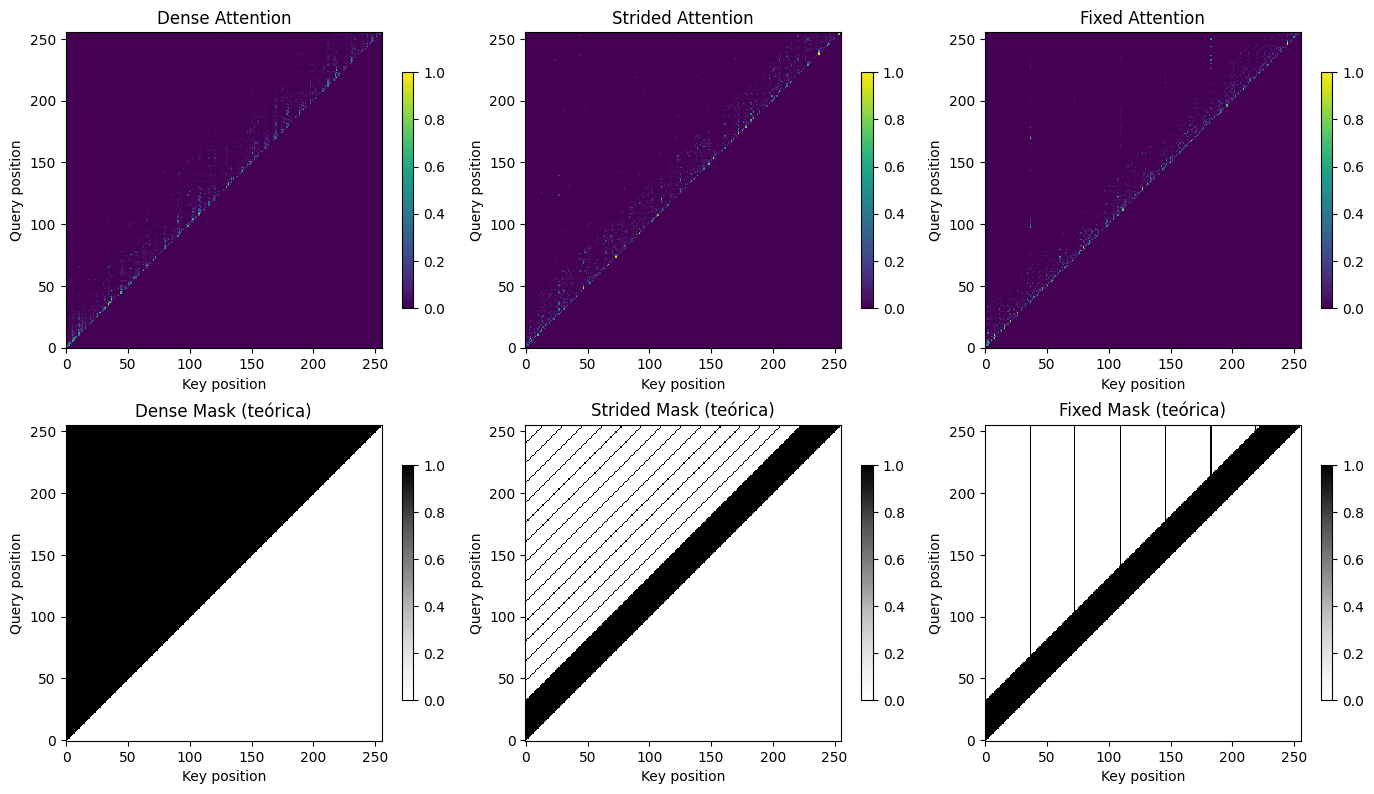

 Figura guardada como attention_vs_masks.png


In [ ]:
## Visualizar pesos de atención de una cabeza concreta

# === función auxiliar para ejecutar y graficar atención ===
def get_attention_matrix(model, mask_fn, seq_len=256):
    """
    Pasa un batch por el modelo, aplica la máscara causal/sparse correspondiente,
    y devuelve la matriz de atención del último layer, head 0: [T, T]
    """
    model.eval()

    # tomar un sample del dataloader
    x, _ = next(iter(train_loader))
    x = x.to(device)  # [B,T]

    with torch.no_grad():
        logits, extra = model(x)  # logits [B,T,V], extra["attentions"]: list of [B,H,T,T]

    # tomar atención del último layer
    attn_layer_last = extra["attentions"][-1]  # [B,H,T,T]

    # obtener la máscara con la misma función usada en el forward
    mask = mask_fn(seq_len, device=device)  # [T,T]
    mask = mask.unsqueeze(0).unsqueeze(0)   # [1,1,T,T]

    # tomar la matriz del batch 0, head 0, último layer
    attn = attn_layer_last[0, 0]  # [T,T]

    # aplicar máscara si no fue aplicada dentro del forward
    attn = attn.masked_fill(~mask[0,0], 0.0)

    return attn.cpu().numpy()


def plot_attentions_with_masks(seq_len=256):

    # === 1. Obtener matrices de atención aprendida ===
    mat_dense = get_attention_matrix(model_dense, build_causal_mask, seq_len)
    mat_strided = get_attention_matrix(model_strided, build_strided_mask, seq_len)
    mat_fixed = get_attention_matrix(model_fixed, build_fixed_mask, seq_len)

    # === 2. Obtener máscaras teóricas en 2D ===
    mask_dense = build_causal_mask(seq_len, device=device).cpu().numpy()
    mask_strided = build_strided_mask(seq_len, device=device).cpu().numpy()
    mask_fixed = build_fixed_mask(seq_len, device=device).cpu().numpy()

    # === 3. Crear figura 2x3 ===
    fig, axs = plt.subplots(2, 3, figsize=(14, 8))

    # --- FILA 1: Atención aprendida ---
    attn_mats = [mat_dense, mat_strided, mat_fixed]
    attn_titles = ["Dense Attention", "Strided Attention", "Fixed Attention"]

    for ax, mat, title in zip(axs[0], attn_mats, attn_titles):
        im = ax.imshow(mat, cmap="viridis", interpolation="nearest")
        ax.set_title(title)
        ax.set_xlabel("Key position")
        ax.set_ylabel("Query position")
        ax.invert_yaxis()
        fig.colorbar(im, ax=ax, shrink=0.7)

    # --- FILA 2: Máscaras teóricas ---
    mask_mats = [mask_dense, mask_strided, mask_fixed]
    mask_titles = ["Dense Mask (teórica)", "Strided Mask (teórica)", "Fixed Mask (teórica)"]

    for ax, mat, title in zip(axs[1], mask_mats, mask_titles):
        im = ax.imshow(mat, cmap="Greys", interpolation="nearest")
        ax.set_title(title)
        ax.set_xlabel("Key position")
        ax.set_ylabel("Query position")
        ax.invert_yaxis()
        fig.colorbar(im, ax=ax, shrink=0.7)

    plt.tight_layout()

    # Guardar resultado
    fig.savefig("attention_vs_masks.png", dpi=300)
    plt.show()

    print(" Figura guardada como attention_vs_masks.png")

# === ejecutar ===
plot_attentions_with_masks()


In [ ]:
def plot_attention_all_layers(model, dataloader, device="cuda", head=0, seq_len=None):
    """
    Visualiza la atención de TODAS las capas del modelo.

    - model: modelo entrenado (dense, strided, fixed)
    - dataloader: train_loader o valid_loader
    - device: "cuda" o "cpu"
    - head: cabeza específica a visualizar
    - seq_len: si se quiere recortar T (opcional)
    """

    model.eval()

    # 1. Obtener un batch
    x, _ = next(iter(dataloader))
    x = x.to(device)

    # 2. Forward para obtener atenciones
    with torch.no_grad():
        logits, extra = model(x)

    attentions = extra["attentions"]   # lista [n_layers] con tensores [B,H,T,T]
    n_layers = len(attentions)

    # 3. Crear figura: 1 fila × n_layers columnas
    fig, axs = plt.subplots(1, n_layers, figsize=(4 * n_layers, 4))

    if n_layers == 1:
        axs = [axs]  # para manejar caso de 1 sola capa

    # 4. Graficar atención por capa
    for i, attn in enumerate(attentions):
        attn_matrix = attn[0, head].cpu().numpy()  # [T,T]

        # recortar secuencia si se pidió
        if seq_len is not None:
            attn_matrix = attn_matrix[:seq_len, :seq_len]

        im = axs[i].imshow(attn_matrix, interpolation="nearest", cmap="viridis")
        axs[i].set_title(f"Layer {i} (head {head})")
        axs[i].set_xlabel("Key position")
        axs[i].set_ylabel("Query position")
        axs[i].invert_yaxis()

        fig.colorbar(im, ax=axs[i], shrink=0.6)

    plt.tight_layout()
    plt.show()


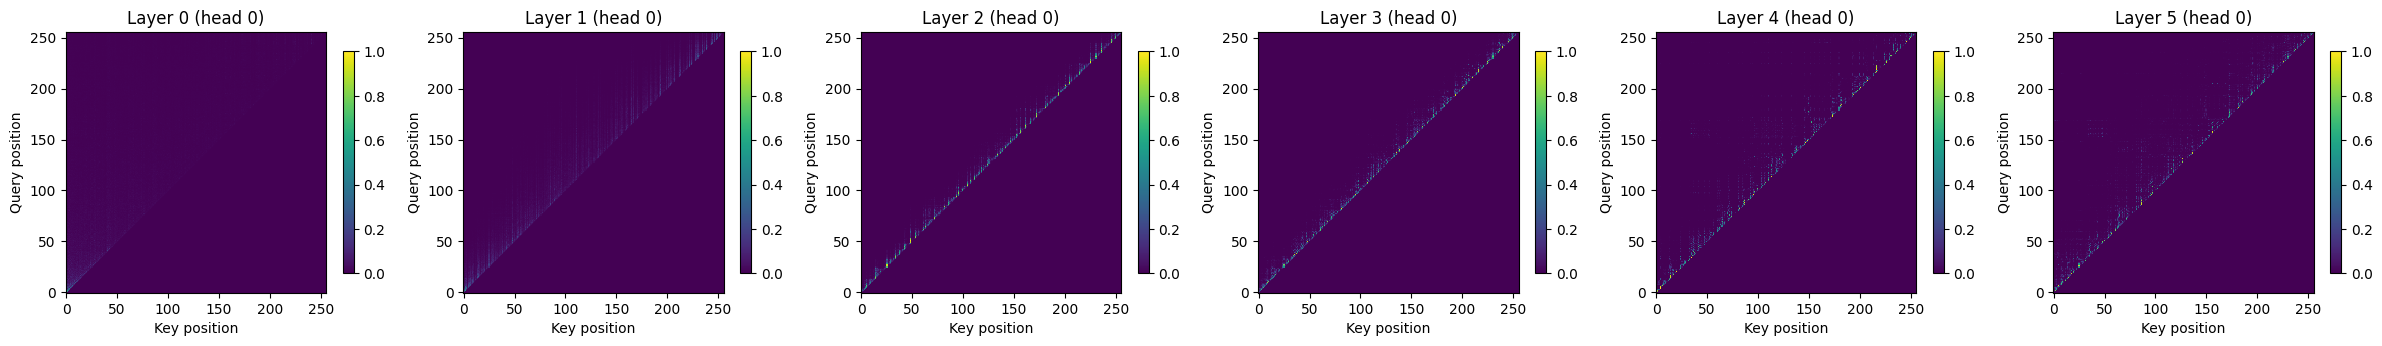

In [ ]:
plot_attention_all_layers(
    model_dense,
    dataloader=train_loader,
    device=device,
    head=0,
    seq_len=256
)

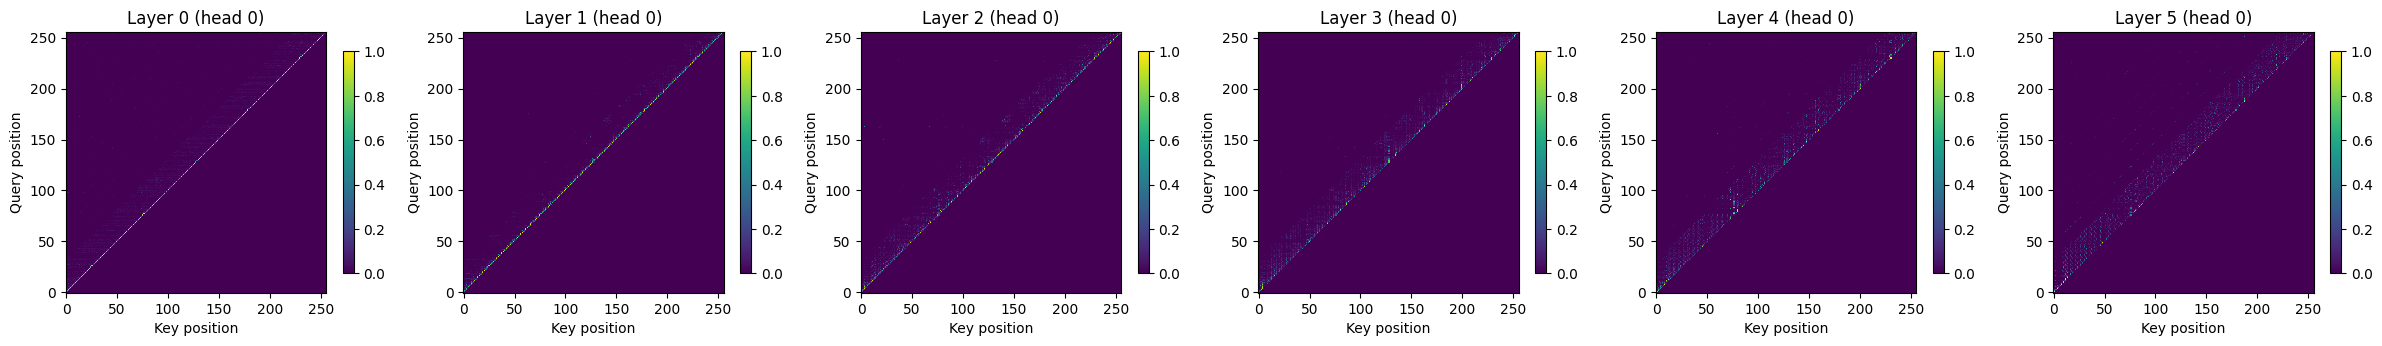

In [ ]:
plot_attention_all_layers(
    model_strided,
    dataloader=train_loader,
    device=device,
    head=0,
    seq_len=256
)

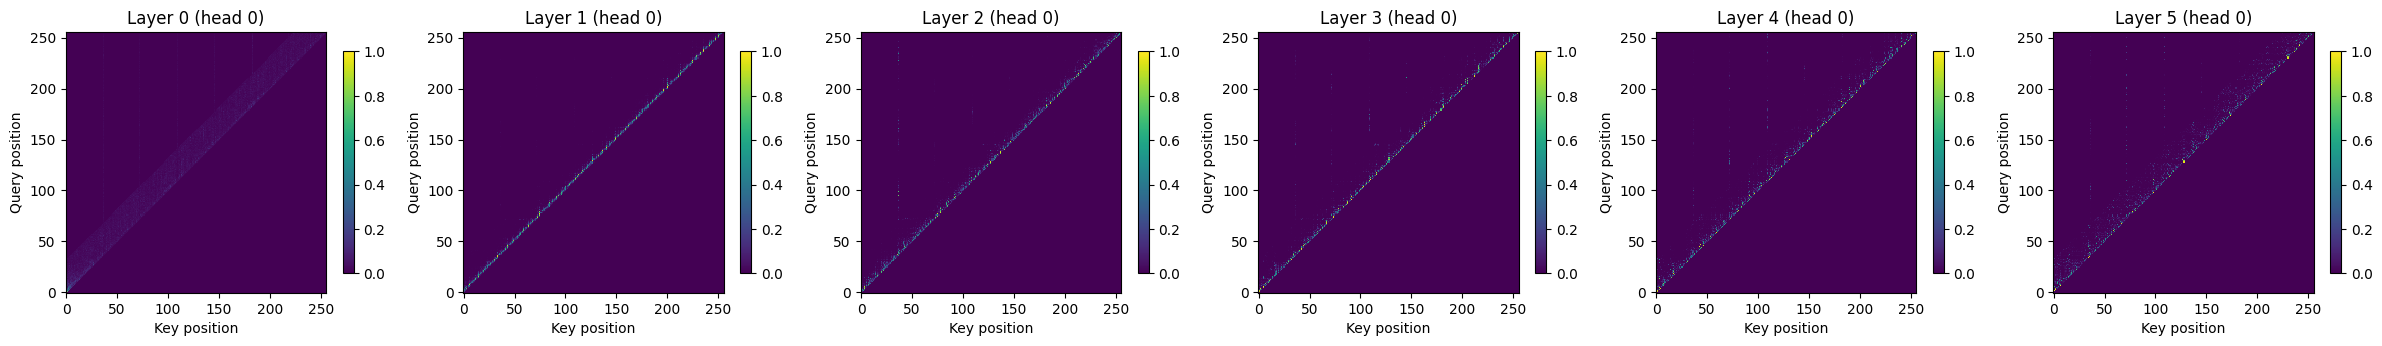

In [ ]:
plot_attention_all_layers(
    model_fixed,
    dataloader=train_loader,
    device=device,
    head=0,
    seq_len=256
)